# 1 Mastering Advanced Network Construction

Complex networks are rarely constructed one node and one edge at a time.
Instead, they are generated from **matrix data**, **edge lists**, **node dictionaries**,
**probability distributions**, and other native Python and third-party data
structures. As a complex network analyst, you need to be familiar with the
**NetworkX interfaces to the real world**.

In this section, you will learn:

- how to convert Python and third-party data structures (namely, **Pandas DataFrames** and **NumPy matrices**) into **NetworkX** graphs and back, and 
- how to generate synthetic networks.

## 1.1 Create Networks from Adjacency and Incidence Matrices

Mathematical graphs as collections of nodes and edges are
not the only way to represent complex networks. Researchers
and practitioners often use tabular (matrix) data to describe
networks. The two most popular matrix-based descriptions
are **adjacency** and **incidence matrices**.

### 1.1.1 Adjacency Matrix, the Python Way




An adjacency matrix A is a square $N\times N$ matrix, where $N$ is the size of the graph
to be defined. The row and column indexes indicate the source and target
nodes, respectively. Depending on the network type, the acceptable range,
properties, and interpretation of the matrix elements differ. If a network
belongs to more than one type (say, weighted and directed), consider all relevant
properties and interpretations (see table below).


| Network type    | Adjacency matrix                              | Interpretation                               |
|-----------------|-----------------------------------------------|----------------------------------------------|
| Simple          | Only 0s or 1s, and no 1s on the main diagonal | Absence/presence of an edge                  |
| Weighted        | At least one floating-point number            | Numbers are edge weights                     |
| With self-loops | At least one non-zero on the main diagonal    | Same as above                                |
| Signed          | At least one negative number                  | Same as above                                |
| Undirected      | Symmetric                                     | Same as above                                |
| Multigraph      | Not possible                                  | Cannot be represented as an adjacency matrix |


As an example, here’s an adjacency matrix for the linear timeline of Abraham
Lincoln:

<img width="200" src="https://drive.google.com/uc?export=view&id=1661N-zE4kC5LfQGa33hUCyi9Q5C0b_DX"> <img width="200" src="https://drive.google.com/uc?export=view&id=1HpWEIsxBcY1FWI1UYQdgudViRpURDecB">


The networks have five nodes each (the matrices are $5\times5$). The left network
has four edges (the matrix has four 1s), and the right network has an extra
edge. The networks are simple (the matrices have only 0s and 1s, and no 1s
are on the main diagonal), unweighted, and unsigned. The networks are
directed (the matrices are not symmetric). The additional 1 in the lower-left
corner of the matrix on the right converts the linear network into a ring by
connecting the last event (death) to the first event (birth). If Abraham Lincoln had
believed in reincarnations, he would have chosen the right matrix :-)


As a side note, **the sum of all 1s in any column or row of an adjacency matrix
equals the indegree or outdegree**, respectively, of the corresponding node.
The most common way of representing matrices in pure **Python** is in the form
of a **list of lists**. The right previous matrix is a list of five lists, one list per row.
Suppose it is given to us (say, produced by another function elsewhere in our
program):

In [0]:
A = [[0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1],
     [.1, 0, 0, 0, 0]]
A

[[0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [0.1, 0, 0, 0, 0]]

Note that since the reincarnation is not inevitable at all, not even in the case
of Honest Abraham, we set the weight of the death-to-birth edge to 0.1.

**How can we convert this matrix to a graph?** There are at least three ways:
- one uses pure Python and NetworkX,
- and the other rely on NumPy  
- and Pandas

If performance is not an issue (if your network has fewer than a couple of
thousand nodes), the pure Python solution may make you feel more comfortable,
especially if you have never used NumPy. 

Remember that any non-zero element in the adjacency matrix represents an edge from the “row node” to the “column node.” Create an empty directed graph, enumerate each matrix
element twice (by rows and then by columns), and extract non-zero elements.
Their indexes represent network edges, which you can add to the graph by
calling **G.add_edges_from()**.

In [0]:
import networkx as nx
  
# directed graph  
G = nx.DiGraph()

# nested list comprehension
edges = [(i,j) for i,row in enumerate(A) for j,column in enumerate(row) if A[i][j]]

# add edges
G.add_edges_from(edges)

print(G.edges(data=True))

[(0, 1, {}), (1, 2, {}), (2, 3, {}), (3, 4, {}), (4, 0, {})]


By default, NetworkX assumes that all edges have the weight of 1, and does not
display weights as edge attributes. If the matrix represents signed or unsigned
weights (rather than absence/presence), you can modify the code to incorporate
the “weight” attribute:

In [0]:
# directed graph  
G = nx.DiGraph()

# nested list comprehension
edges = [(i,j, {"weight": A[i][j]}) for i,row in enumerate(A) for j,column in enumerate(row) if A[i][j]]

# add edges
G.add_edges_from(edges)

print(G.edges(data=True))

[(0, 1, {'weight': 1}), (1, 2, {'weight': 1}), (2, 3, {'weight': 1}), (3, 4, {'weight': 1}), (4, 0, {'weight': 0.1})]


### 1.1.2 Adjacency Matrix, the Numpy Way

The NumPy way is somewhat more concise, but you must convert the list of
lists to a 2D matrix and give NetworkX a hint about the network type.

In [0]:
import numpy as np

A_mtx = np.matrix(A)
G = nx.from_numpy_matrix(A_mtx, create_using=nx.DiGraph())

print(G.edges(data=True))

[(0, 1, {'weight': 1.0}), (1, 2, {'weight': 1.0}), (2, 3, {'weight': 1.0}), (3, 4, {'weight': 1.0}), (4, 0, {'weight': 0.1})]


As a bonus, the **Numpy is significantly faster for large networks**. Also, note
how Numpy intelligently treated matrix elements as edge weights!
You can program the reverse transformation with **nx.to_numpy_matrix(G)**:

In [0]:
# Produces a numpy 2D matrix
B_mtx = nx.to_numpy_matrix(G)

print(B_mtx)

[[0.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.1 0.  0.  0.  0. ]]


To convert the matrix back to a list of lists, call method tolist():

In [0]:
B_lst = B_mtx.tolist()
B_lst

[[0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.1, 0.0, 0.0, 0.0, 0.0]]

### 1.1.3 Adjacency Matrix, the Pandas Way

The most versatile connection to date is between NetworkX and Pandas. Converting a NetworkX graph to a Pandas adjacency matrix **costs one function
call**, just like almost any other popular operation in Pandas. Before we do
so, let’s first relabel the graph nodes to allow at least some meaningful
interpretation:

In [0]:
labels = "Born", "Married", "Elected Rep", "Elected Pres", "Died"

# change nodes label inplace
nx.relabel_nodes(G, dict(enumerate(labels)), copy=False)

# create a dataframe from a networkx graph
df = nx.to_pandas_adjacency(G)

df

,Born,Married,Elected Rep,Elected Pres,Died
Born,0.0,1.0,0.0,0.0,0.0
Married,0.0,0.0,1.0,0.0,0.0
Elected Rep,0.0,0.0,0.0,1.0,0.0
Elected Pres,0.0,0.0,0.0,0.0,1.0
Died,0.1,0.0,0.0,0.0,0.0


In [0]:
edges = nx.to_pandas_edgelist(G)
edges

,source,target,weight
0,Born,Married,1.0
1,Married,Elected Rep,1.0
2,Elected Rep,Elected Pres,1.0
3,Elected Pres,Died,1.0
4,Died,Born,0.1


Let’s build Honest Abraham's lifetime network from a data frame. First, create a
data frame—in the real world, it would be an output of another part of the
same program. Second, call **nx.from_pandas_adjacency()**. No magic involved.


In [0]:
import pandas as pd

edges = pd.DataFrame({"from": {0: "Died", 1: "Elected Rep", 2: "Married", 3: "Born",4: "Elected Pres"},
                   "to": {0: "Born", 1: "Elected Pres", 2: "Elected Rep", 3: "Married",4: "Died"},
                   "weight": {0: 0.1, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}})
edges

,from,to,weight
0,Died,Born,0.1
1,Elected Rep,Elected Pres,1.0
2,Married,Elected Rep,1.0
3,Born,Married,1.0
4,Elected Pres,Died,1.0


In [0]:
G = nx.from_pandas_edgelist(edges,
                            *edges.columns,
                            create_using=nx.DiGraph())
G.edges(data=True)

OutEdgeDataView([('Born', 'Married', {'weight': 1.0}), ('Married', 'Elected Rep', {'weight': 1.0}), ('Elected Rep', 'Elected Pres', {'weight': 1.0}), ('Elected Pres', 'Died', {'weight': 1.0}), ('Died', 'Born', {'weight': 0.1})])

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


The [Enron email network](http://snap.stanford.edu/data/email-Enron.html) consists of 1,148,072 emails sent between employees of Enron between 1999 and 2003. Nodes in the network are individual employees and edges are individual emails. It is possible to send an email to oneself, and thus this network contains loops. In this exercise we will use a subset of Enron email consists of 36692 nodes and 367662 edges.

1. Read the file **"email-Enron.txt"** (tip: columns are separeted by a "\t") to a dataframe named **"edges"**. 
2. Use **nx.from_pandas_edgelist()** to create a directed graph **g_enron** from **"edges"**. tip: configure the parameter **create_using** to **nx.Digraph**.
3. Find the number of nodes and edges of **g_enron**.

In [0]:
# put your code here

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

1. Read the file **"out.enron"** (tip: columns are separeted by a white space) to a dataframe named **"edges2"**. 
2. Use **nx.from_pandas_edgelist()** to create a directed graph **g_enron2** from **"edges2"**
  - configure the parameter **create_using** to **nx.Digraph**.
  - source to **"From"**
  - target to **"To"**
  - edge_attr to a list contains **"Weight"** and **"Timestamp"**.
3. Find the number of nodes and edges of **g_enron2**.
4. Visualize the data of **edges2**.

In [0]:
# put your code here

### 1.1.4 Incidence Matrix




An incidence matrix J is a rectangular $N\times M$ matrix, where 
- $N$ is the number of
nodes 
- and $M$ is the number of edges. 
- a 1 at J[i,j] means that the node i is incident to the edge j. 
- all other elements of J are 0s. 
- if the represented graph is directed, the start node is designated with 1 and the end node with -1.

Unlike an adjacency matrix, **an incidence matrix easily allows parallel edges**.

However, it has its **weak points**: 
- weighted networks cannot be represented
- and an incidence matrix of a typical complex network has a larger memory
footprint than the adjacency matrix of the same network.

Function **nx.incidence_matrix(G)** returns the incidence matrix of G as a so-called
**sparse matrix**. (Pass the optional parameter **oriented=True** to distinguish start
and end nodes.) You can convert a sparse matrix to a dense one with **G.todense()**:



In [0]:
J = nx.incidence_matrix(G, oriented=True).todense()
J

matrix([[-1.,  0.,  0.,  0.,  1.],
        [ 1., -1.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  1., -1.]])

Here’s how we read the results: edge number 0 starts at node 1 (because
J[1,0]==1) and ends at node 0 (because J[0,0]==-1); edge number 1 starts at node
3 (because J[3,1]==1) and ends at node 0 (because J[0,1]==-1), and so on.

In [0]:
import sys
print(sys.getsizeof(nx.incidence_matrix(G, oriented=True)))
print(sys.getsizeof(nx.incidence_matrix(G, oriented=True).todense()))

56
136


## 1.2 Generate Synthetic Networks

You have read in [Complex Network Analysis book](https://pragprog.com/book/dzcnapy/complex-network-analysis-in-python), that not only
can networks be built from experimental, real-world data, but they can also
be **synthesized**. 

Synthetic networks can be regular (constructed by executing
deterministic algorithms) or complex (emerge from probability distributions).
NetworkX functions that build synthetic network graphs are called **graph generators**. Let’s start with the “classic” networks: paths, cycles, stars, complete graphs, trees, and grids.

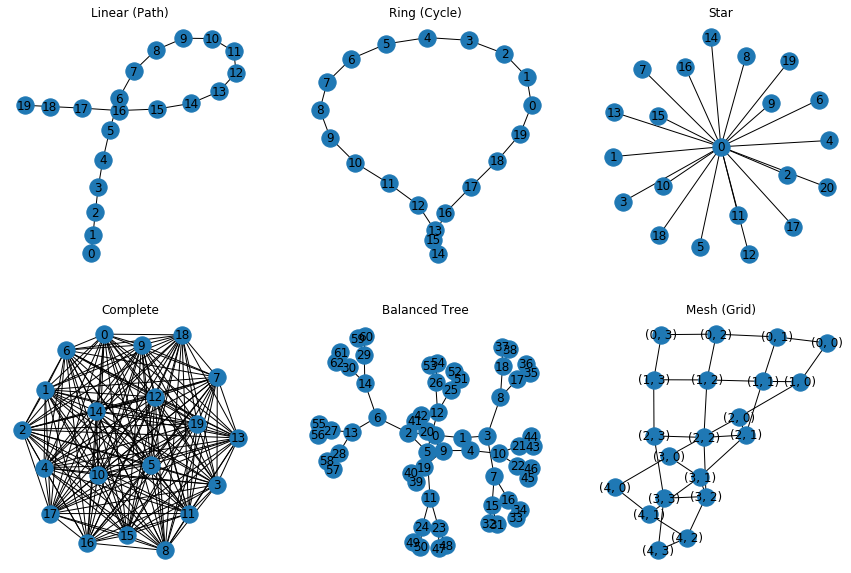

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# Generate and draw classic networks
G0 = nx.path_graph(20)
G1 = nx.cycle_graph(20)
G2 = nx.star_graph(20)
G3 = nx.complete_graph(20)
G4 = nx.balanced_tree(2, 5)
G5 = nx.grid_2d_graph(5, 4)

graphs = [G0,G1,G2,G3,G4,G5]

names = ["Linear (Path)", "Ring (Cycle)", 
         "Star", "Complete", "Balanced Tree", "Mesh (Grid)"]

for graph,title,plot in zip(graphs,names,subplots):
  nx.draw_networkx(graph, ax=plot)
  plot.set_title(title)
  plot.axis("off")

The first four functions need to know the total number of nodes. There is only
one way to generate the edges for these types of graphs. 

For a balanced tree, you must provide the branching factor r (the number of children of a non-leaf node) and the height h (the height does not include the root node of the tree). A balanced tree has $r^{h+1}-1$ nodes. In our example, G5 is a five-level binary tree
with $2^{5+1}-1=63$ nodes. To build a two-dimensional grid (mesh) like G6, specify
the number of rows $n$ and columns $m$, and get a graph with $m\times n$ nodes.


**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

1. Change the paramenters of the previous six graphs and visualize them using Circos Plot (nxviz). tip: nxviz uses networkx 2.2. In this notebook we are using network 2.3. After solve this exercise install again network 2.3. 

In [0]:
!pip install git+https://github.com/ericmjl/nxviz networkx==2.3

In [0]:
# put your code here


It is worth remembering that **these six networks are not complex because
they have a predictable, regular, and easily describable structure**. But the
networks in the following figure are randoms, though defined by four different
random models  characterize the nature of the interconnecting edges:

- **Erdös–Rényi**: the probability of edge creation.
- **Watts–Strogatz**: the initial number of neighbors and the probability of edge rewiring
- **Barabási–Albert**: the number of edges to attach from a new node
- **Holme–Kim**: the same as above, plus the probability of adding a triangle
for each added edge.

An undirected **Erdös–Rényi** graph, also known as a **binomial graph**, contains
$N$ nodes. It could have up to $N\times(N-1)/2$ edges, but each edge is instantiated with the probability of **p**. As a result, the expected number of edges is $p×N×(N-1)/2$.
If $p==0$, then the network falls apart into isolated nodes. If $p==1$, the network
becomes a complete graph. 

Number of edges P(0):0
Number of edges P(0.05):59
Number of edges P(0.1):110
Number of edges P(0.25):315
Number of edges P(0.5):618
Number of edges P(1):1225


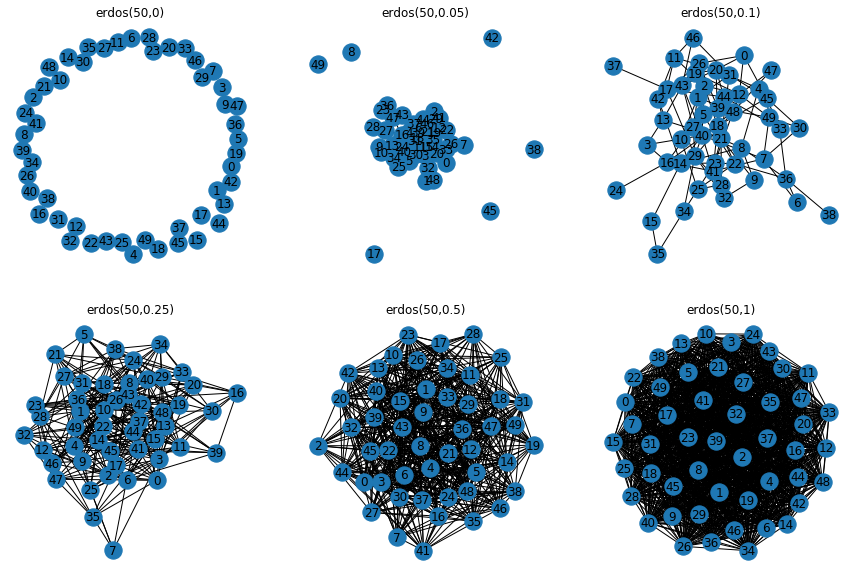

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# probabilities
probs = [0, 0.05, 0.10, 0.25, 0.5, 1]

for prob,plot in zip(probs,subplots):
  # Generate a erdos graph with probability prob
  G0 = nx.erdos_renyi_graph(50, prob)
  print("Number of edges P(" + str(prob) + "):" + str(G0.number_of_edges()))
  nx.draw_networkx(G0, ax=plot)
  plot.set_title("erdos(50," + str(prob) + ")")
  plot.axis("off")

**If you have no definite idea** about what kind of network you want, use the
**Erdös–Rényi** model. 

However, a **Watts–Strogatz** graph is a **much more realistic**
approximation of **a real-world social network**. The model arranges $N$ nodes in
a ring, connects each node to $k$ ring neighbors, and then “rewires” any edge
—reconnects one of its ends to a randomly chosen node—with the probability
of $p$. The rewired edges typically go across the ring. They **create an illusion of a
[small world](https://en.wikipedia.org/wiki/Small-world_network), where geometrically remote nodes may be connected with a short
path**. The model explains the phenomenon of **“six degrees of separation"**, which
claims that, on average, any two people on Earth are only [six handshakes apart
from each other](https://en.wikipedia.org/wiki/Six_degrees_of_separation).

Number of edges P(0):100
Number of edges P(0.05):100
Number of edges P(0.1):100
Number of edges P(0.25):100
Number of edges P(0.5):100
Number of edges P(1):100


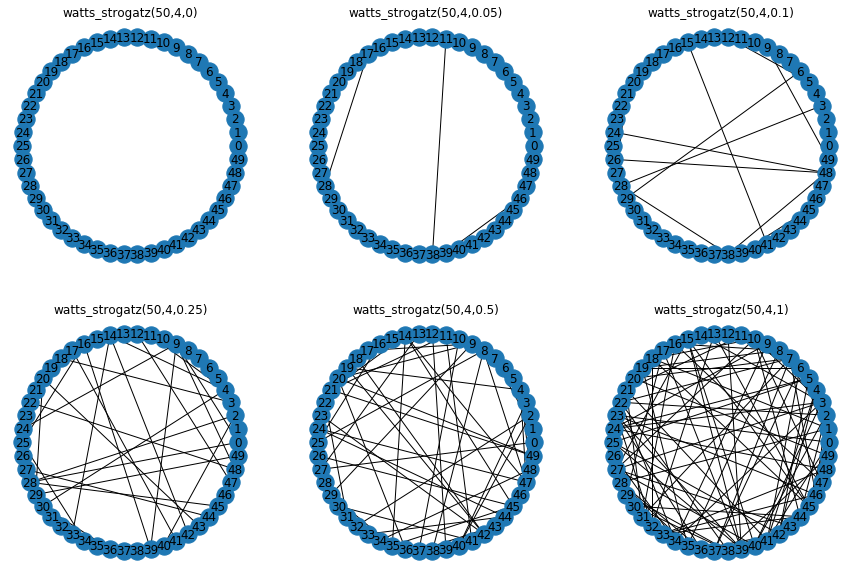

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# probabilities
probs = [0, 0.05, 0.10, 0.25, 0.5, 1]

for prob,plot in zip(probs,subplots):
  # Generate a watts-strogatz graph with probability prob
  G0 = nx.connected_watts_strogatz_graph(50, 4, prob)
  pos = nx.circular_layout(G0)
  print("Number of edges P(" + str(prob) + "):" + str(G0.number_of_edges()))
  nx.draw_networkx(G0, pos=pos, ax=plot)
  plot.set_title("watts_strogatz(50,4," + str(prob) + ")")
  plot.axis("off")

Unfortunately, no matter how you twist them, nodes in **Watts–Strogatz** networks
do not form tight communities, and this **makes “small-world” networks
somewhat unrealistic**, too.

The **Barabási–Albert** preferential attachment model adds another level of realism to synthetic social networks. It uses the **principle of preferential attachment**. When a new node is about to join an existing network, it is likely to make $k$ connections to the
nodes with the highest degree. The model stimulates the emergence of hubs
—“celebrity” nodes with disproportionately many connections.

Number of edges N(1):49
Number of edges N(2):96
Number of edges N(3):141
Number of edges N(4):184
Number of edges N(5):225
Number of edges N(10):400


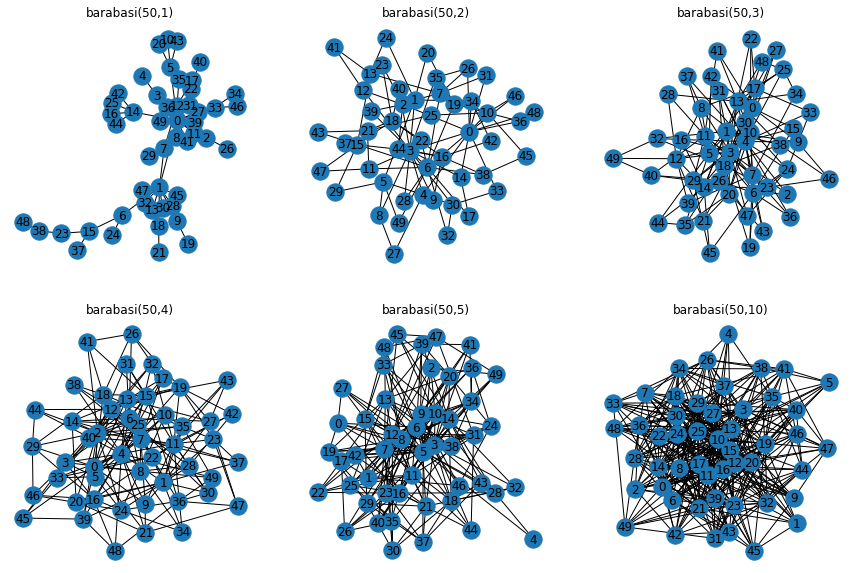

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# number of neighbors
neighs = [1, 2, 3, 4, 5, 10]

for neigh,plot in zip(neighs,subplots):
  # Generate a barabasi graph with k connections to the nodes with the highest degree
  G0 = nx.barabasi_albert_graph(50, neigh)
  print("Number of edges N(" + str(neigh) + "):" + str(G0.number_of_edges()))

  nx.draw_networkx(G0, ax=plot)
  plot.set_title("barabasi(50," + str(neigh) + ")")
  plot.axis("off")

The **Holme–Kim** model goes one step further. After adding $k$ edges, it also adds
**triads** with the probability of $p$, making the synthetic network even more clustered and lifelike.


Number of edges P(0):184
Number of edges P(0.05):183
Number of edges P(0.1):183
Number of edges P(0.25):181
Number of edges P(0.5):181
Number of edges P(1):183


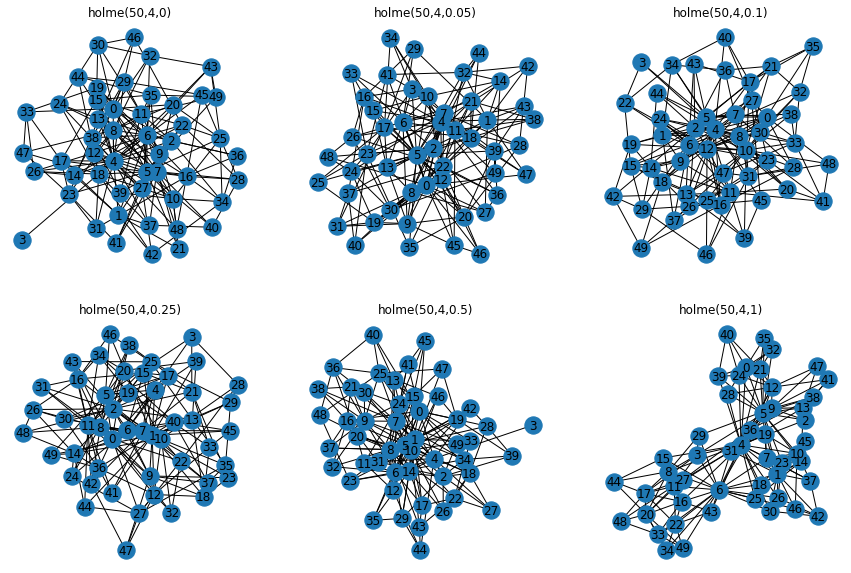

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

fig, plot = plt.subplots(2, 3,figsize=(15,10))
subplots = plot.reshape(1, 6)[0]

# probabilities
probs = [0, 0.05, 0.10, 0.25, 0.5, 1]

for prob,plot in zip(probs,subplots):
  # Generate a holme-kim graph with probability prob
  G0 = nx.powerlaw_cluster_graph(50, 4, prob)
  print("Number of edges P(" + str(prob) + "):" + str(G0.number_of_edges()))

  nx.draw_networkx(G0, ax=plot)
  plot.set_title("holme(50,4," + str(prob) + ")")
  plot.axis("off")

# 2 Measuring Networks

Almost everything you have seen so far in the last section has been about constructing
complex networks, not about analyzing them. In other words, it was CN,
but not CNA. This section delves also into CNA and introduces some important
CNA toolsets. 

- You will learn how to measure **dyadic, triadic**
- and global properties of network nodes: **distances, loops, clustering coefficient, and a variety of centralities**. 
- You will be able to identify the **most central nodes** and interpret their importance. 
- You will be able to **locate network regions** that differ in local density and attribute uniformity.

## 2.1 Start with Global Measures

Let’s start with a **“black box”** view of a complex network. Let’s pretend we are
at a distance and instead of nodes, edges, and their attributes, we see a fuzzy
grayish cloud. What can we tell about that cloud? Not much: only its size and
density.

To be specific, we will experiment with the network of CNA related
Wikipedia pages constructed in previous lesson and available in the file cna.graphml.


In [0]:
import networkx as nx
G = nx.read_graphml("cna.graphml")


The size of a network is either its node count or edge count. You can measure
both using the standard Python len() function and other specialized functions.

In [2]:
nx.number_of_nodes(G)

2995

In [3]:
nx.number_of_edges(G)

11817

**If you’re curious**, you can also get the number of **non-existent edges**—the
edges that could connect two nodes but don’t. The function **nx.non_edges()**
returns a Python generator of missing edges. Before measuring it, you must
convert it to a list. **Beware: most real-life graphs have orders of magnitude
more missing edges than present edges. Your computer may quickly run out
of memory if you attempt to make a list out of them.**

In [4]:
len(list(nx.non_edges(G)))

8955213

**GRAPH DENSITY** measures the fraction of existing edges out of all potentially
possible edges. Density is a number between 0 and 1, inclusive. 

- A network with density 0 has no edges whatsoever. 
- A network with density 1 is a complete graph. 

For a directed network with $n$ nodes and $m$ edges, density is calculated
as $\frac{m}{n(n-1)}$; for undirected networks, it is calculated as $\frac{2m}{n(n-1)}$, because, compared to directed networks, they have only half of potentially possible
edges. You can measure density by calling a namesake function.

In [5]:
nx.density(G)

0.001317827641928264

The density of the Wikipedia network is low—only about 0.1 percent. **Only
one out of about 1,000 possible edges exists in the graph**. This value is not
unusual: most complex networks have similarly low density.


**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



1. Find the graph density for Enron network (**"email-Enron.txt"**).


In [0]:
# put your code here

## 2.2 Explore Neighborhoods

Node and edge counts and density are some of the **macroscopic network
properties.**  Let us now zoom into a network and look at it at the **microscopic
level**—at the level of individual nodes and their neighbors.


The **network neighborhood** of a node is the set of all nodes adjacent to that
node. Social network analysis pays particular attention to neighborhoods
because that is where we find the relatives, close friends, and colleagues of
the actor represented by the central node—in other words, the most socially
significant alters of the ego. **Neighborhoods are responsible for
the local properties of network graphs.**

NetworkX offers two mechanisms for calculating neighborhoods.

In [7]:
ego = "Neighbourhood (Graph Theory)"

alters_1 = G[ego]
print(alters_1)

{'Degree (Graph Theory)': {}, 'Isolated Vertex': {}, 'Chordal Graph': {}, 'Complete Graph': {}, 'Turán Graph': {}, 'Loop (Graph Theory)': {}, 'Linear Time': {}, 'Gerhard Ringel': {}, 'Adjacency List': {}, 'Clustering Coefficient': {}, 'Independent Set (Graph Theory)': {}, 'Planar Graph': {}, 'Discrete Mathematics (Journal)': {}, 'Chromatic Number': {}, 'Vertex Figure': {}, 'Adjacency Matrix': {}, 'Graph Theory': {}, 'Independence Number': {}, 'Graph Isomorphism': {}, 'Dense Graph': {}, 'Cycle Graph': {}, 'Triangle-Free Graph': {}, 'Perfect Graph': {}, 'Induced Subgraph': {}, 'Vertex (Graph Theory)': {}, 'Octahedron': {}, 'Graph (Discrete Mathematics)': {}, 'Edge (Graph Theory)': {}, 'Modular Decomposition': {}, 'Complement Graph': {}, 'Journal Of The Acm': {}, 'Neighbourhood (Mathematics)': {}}


In [8]:
print(len(alters_1))

32


In [11]:
alters_2 = list(nx.all_neighbors(G, ego))
print(alters_2)
print(len(alters_2))

['Interdependent Networks', 'Semantic Network', 'Scientific Collaboration Network', 'Biological Network', 'Clustering Coefficient', 'Community Structure', 'Modularity (Networks)', 'Boolean Network', 'Network Motif', 'Exponential Random Graph Model', 'Complex Network', 'Hyperbolic Geometric Graph', 'Computer Network', 'Watts And Strogatz Model', 'Efficiency (Network Science)', 'Hierarchical Network Model', 'Random Graph', 'Social Network', 'Scale-Free Network', 'Erdős–Rényi Model', 'Network Theory', 'Telecommunications Network', 'Network Science', 'Transport Network', 'Barabási–Albert Model', 'Spatial Network', 'Small-World Network', 'Reciprocity In Network', 'Reciprocity (Network Science)', 'Degree (Graph Theory)', 'Isolated Vertex', 'Chordal Graph', 'Complete Graph', 'Turán Graph', 'Loop (Graph Theory)', 'Linear Time', 'Gerhard Ringel', 'Adjacency List', 'Clustering Coefficient', 'Independent Set (Graph Theory)', 'Planar Graph', 'Discrete Mathematics (Journal)', 'Chromatic Number', 'V

In [12]:
# nx.all_neighbors is the same of the "degree" of a node
nx.degree(G,ego)

61

Note that the two methods report a different number of nodes in the neighborhoods
alters_1 and alters_2: 32 and 61, respectively. 

Recall that the network G is directed. **The first method returns only the neighbors reachable by the outgoing edges—the out-neighborhood. The second method returns all adjacent nodes, regardless of the direction of adjacency.** Which method to use depends on
which result you’re looking for.


### 2.2.1 Egocentric Network



A neighborhood is a **dyadic structure**. It’s defined in terms of connections
between two nodes: the **ego** and an **alter**. Aside from serving as a reference
to the ego’s inner circle, it conveys little information. For example, it doesn’t
tell if and how its members are interconnected. Adding the chord edges
transforms the sparse neighborhood into an **egocentric network**. 

- **An egocentric network** (or ego network, for short) is the social network of a
particular individual. An ego network includes all the individual’s contacts
and all the relationships among them.

Call function **nx.ego_graph()** to obtain the egocentric
network graph.

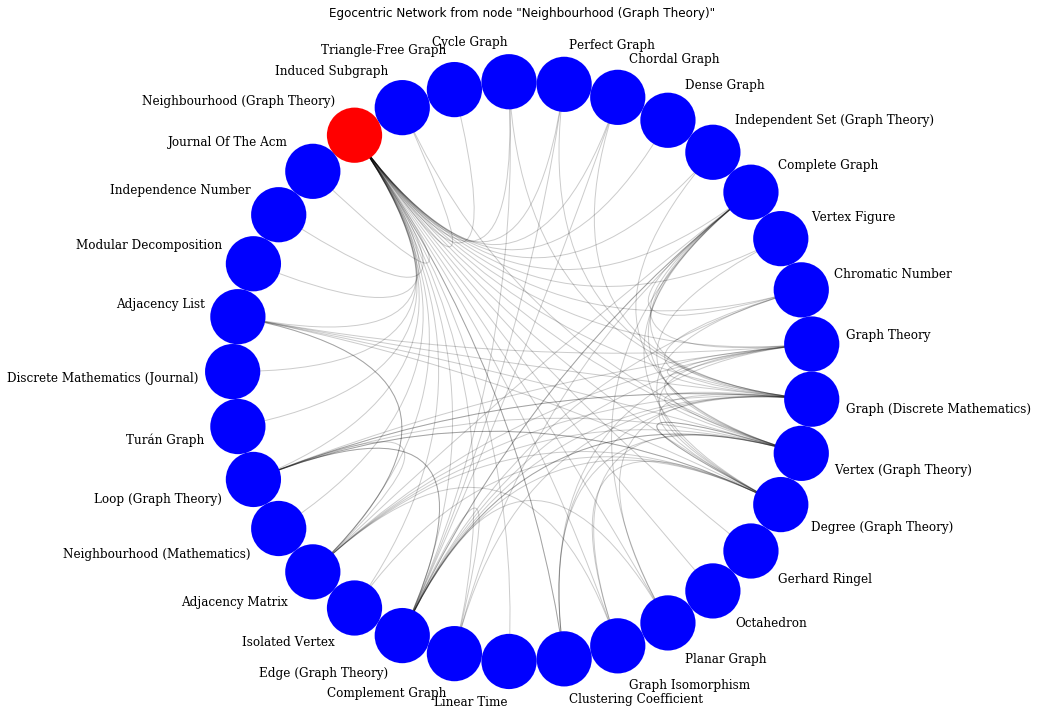

In [0]:
# Import necessary modules to use Circos plot
import matplotlib.pyplot as plt
from nxviz import CircosPlot 

# create an egocentric network from ego and G
egonet = nx.ego_graph(G, ego)

# Create the CircosPlot object: c
c = CircosPlot(egonet,
               node_labels=True,
               figsize = (15,10),
               nodeprops={"radius": 0.5},
               #node_label_layout="rotation",
               #node_label_layout="numbers",
               fontsize=12
               )

# find ego node
for i,label in enumerate(c.nodes):
  if label == ego:
    ego_index = i
    break

# Draw c to the screen
c.node_colors[ego_index] = "red"
c.draw()
c.figure.tight_layout()

# Display the plot
plt.title("Egocentric Network from node \"{}\"".format(ego))
plt.show()

The figure shows the egocentric network of ego. The network is
much denser. You can see that some nodes are connected only to the hub
(and possibly to some more remote nodes), while others form triangles that
involve more neighborhood members.

### 2.2.2 Clustering Coefficient



Some social theories consider **triads** essential units of social network analysis.
Function [nx.clustering(G, nodes=None)](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html) calculates the **clustering coefficient**
- a measure of the prevalence of triangles in an egocentric network. 
- the clustering coefficient is the fraction of possible triangles that contain the ego node and
exist. 

This measure is undefined for directed graphs; you must coerce a
digraph to an undirected graph before calculating the clustering coefficient.
The following code fragment shows how to call the function:

In [8]:
cc = nx.clustering(nx.Graph(G), ego)
cc

0.39378531073446327

- If the **clustering coefficient** of a node is 1, the node participates in every
possible triangle involving any pair of its neighbors; **the egocentric network
of such a node is a complete graph**. 
- If the **clustering coefficient** of a node is 0, no two nodes in the neighborhood are connected; the **egocentric network
of such node is a star**. 

Think of the clustering coefficient as a measure of “stardom.”

> Just like some other terms, the term **“clustering”** refers to at least
three different concepts: 
- the separation of a network into compact,
tightly knit communities 
- the measure of the density of an egocentric network
- the task of grouping relational data objects into subsets with
similar properties

Function [nx.average_clustering()](https://networkx.github.io/documentation/stable/reference/algorithms/clustering.html) calculates the mean clustering coefficient for all
nodes of a simple network (no loops, no directed or parallel edges).


In [9]:
acc = nx.average_clustering(nx.Graph(G))
acc

0.7155239923349956

In [17]:
import numpy as np

# the same code of nx.average_clustering()
undirect_g = nx.Graph(G)
acc_2 = np.mean([nx.clustering(undirect_g, node) for node in G.nodes])
acc_2

0.7155239923349953

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


1. Create a histogram and a box plot considering the clustering metric (**nx.clustering()**) for all nodes in the graph G. What is your conclusion?
2. Draw a scatter plot comparing the **Degree** metric (axis x) and **Clustering** metric (axis y) for all nodes in graph G. What is your conclusion?

In [0]:
# put your code here

## 2.3 Think in Terms of Paths

### 2.3.1 Walk, trail and path

Both **dyadic** and **triadic** relationships are local and never go farther than one
edge (or one “hop,” as network researchers say) from any of the involved
nodes. The purpose of the functions in this section is to take you far away—
as far as your network can afford.

For that, you need definitions of a **walk**, **trail**, and **path**.

- a walk in a network is **any sequence of edges** such that the end of one
edge is always the beginning of another edge, except possibly for the first
and last edges that may be connected only at one end.
- a trail is a **walk that never uses the same edge twice**. A trail that does not
intersect itself, but starts and ends at the same node, is called a **cycle**. 
- a path is a trail that **never visits the same node twice** (in other words, it
does not intersect itself; NetworkX refers to paths as “simple paths”).


<img width="500" src="https://drive.google.com/uc?export=view&id=1csDcqhbvBtRCoV8BVyTbD2rwhQoiquk2">

Any of these walks is directed if any of its constituent edges is directed. For
the rest of the material, we will use only paths.

**A path has the length**. The length of a path in an unweighted network is the
number of edges in the path. When it comes to weighted paths, it is up to
you to decide how to calculate the length. Possible metrics include the number
of edges, the sum of the weights, the harmonic average of the weights, and
the largest or the smallest weight.

A path is a highway across the network that indirectly connects the nodes
that are not adjacent to each other, and allows them to interact. The meaning
of the remote interaction is specific to each class of complex networks. 
- In a social network, a path of length 3 connects the ego to the friend-of-a-friend- of-
a-friend. 
- In the network of Wikipedia pages, a path of length 3 connects the page about neighborhoods to a page that is similar to a similar page.
- In a transportation network, a node three hops away is the destination you can
get to by changing trains twice. 
- In some networks (like the network of foods and nutrients), long paths make no sense at all.


Two nodes in a network are often connected with more than one path. If paths
matter at all, the shortest of them matters the most. (Again, there may be
more than one shortest path between two nodes.) **The shortest paths are
called geodesics.**


Not only does NetworkX provide a set of tools for computing with paths, but it
also uses them for component detection and centrality calculation, to name
a few applications. Function [nx.shortest_simple_paths(G,u,v)](https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.simple_paths.shortest_simple_paths.html) returns a generator of
all simple paths in the graph G from source to target. You can expand the generator
into a list, but beware: it may take the program hours and even days to elicit
all shortest paths in a large graph. Use this function with care! For example,
you can get one path at a time by calling **next()**.

In [18]:
# return a generator that produces lists of simple paths, in order from shortest to longest.
path_gen = nx.shortest_simple_paths(G, ego, "Webgraph")
next(path_gen)

['Neighbourhood (Graph Theory)',
 'Degree (Graph Theory)',
 'Degree Distribution',
 'Scale-Free Network',
 'Webgraph']

In [19]:
next(path_gen)

['Neighbourhood (Graph Theory)',
 'Adjacency List',
 'Computer Science',
 'World Wide Web',
 'Webgraph']

In [21]:
next(path_gen)

['Neighbourhood (Graph Theory)',
 'Clustering Coefficient',
 'Random Graph',
 'Pagerank',
 'Webgraph']

Function [nx.shortest_path()](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) returns only one of the shortest
paths between source and target.

In [15]:
nx.shortest_path(G,ego,"Webgraph")

['Neighbourhood (Graph Theory)',
 'Degree (Graph Theory)',
 'Degree Distribution',
 'Scale-Free Network',
 'Webgraph']

### 2.3.2 Networks as Circles

Reportedly, people used to believe that the Earth was flat and round, but
later changed their mind and settled on the geoid—an ellipsoid-like, but not
exactly ellipsoidal body. We are going the opposite way: our complex networks
started as shapeless clouds, but at this point let’s try to treat them as flat
and round.


CNA offers a concept of node **eccentricity** — a measure of how far from (or close
to) the center a node is, wherever the center is. 
- The eccentricity is the maximum distance from a node to all other nodes in the network. 

The distance between two nodes is naturally defined as the length of the geodesic between
the two nodes. Function [nx.eccentricity(G,v=Node)](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.distance_measures.eccentricity.html) returns the eccentricity for one
node v or the whole graph. Note that in a directed graph, there may be no
directed geodesics for some pairs of nodes. You must decide if it is appropriate
to coerce the digraph to an undirected graph.

In [12]:
ecc = nx.eccentricity(nx.Graph(G))
ecc[ego]

3

The **remaining “circular”** network properties are defined through the **eccentricity**. If you already calculated it, do not throw it away, but pass to the following functions for the sake of performance.

- The **diameter** of a network is the maximum eccentricity. If two nodes are
as far apart as possible, they must be at the diametrically opposite ends
of the network, right?
- The **radius** of a network is the minimum eccentricity. This definition is
not intuitive, but it is what it is. What’s more counterintuitive, in general,
is that the radius is not a half of the diameter.
- The **center** of a network is a set of all nodes whose eccentricity equals the
radius. Another not very intuitive definition—but it yields a surprisingly
accurate result (see the following example).
- The **periphery** of a network is a set of all nodes whose eccentricity equals
the diameter. The set of peripheral nodes in a complex network is usually
large.

**FLAT CODE VERSION**



In [24]:
# diameter = max(ecc)
ecc[max(ecc,key=ecc.get)]

4

In [25]:
# radius = min(ecc)
ecc[min(ecc,key=ecc.get)]

2

In [26]:
# center => set of nodes with ecc equal to radius
[i for i in ecc if ecc[i] == ecc[min(ecc,key=ecc.get)]]

['Complex Network']

In [27]:
# periphery => set of nodes with ecc equal to diameter
len([i for i in ecc if ecc[i] == ecc[max(ecc,key=ecc.get)]])

2875

**USING OPTIMIZED FUNCTIONS**

In [28]:
nx.diameter(G,e=ecc)

4

In [29]:
nx.radius(G,e=ecc)

2

In [30]:
nx.center(G,e=ecc)

['Complex Network']

In [31]:
len(nx.periphery(G,e=ecc))

2875

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



1. Find the frequency distribution of excentricity metric for all devices in graph G.
  - Use as base the object **ecc** found previously
  - Import **Counter** function from **collections**
  - Convert ecc.values() for a list and pass it as parameter to **Counter**
2. Create a histogram of frequency distribution using ecc.values()

In [0]:
# put your code here

## 2.4 Choose the Right Centralities

One of the goals of social network analysis is to **identify
actors with outstanding properties**: the most influential, the
most efficient, the most irreplaceable—in other words, the
**most important**. CNA, in general, is also looking at the most
important nodes: key products in product networks; key
words in semantic networks; key events in the networks of events, and the
like. One of the central premises of CNA is that the importance of a node
depends on the structural position of the node in the network and can be
calculated from neighborhoods, geodesics, or some other structural elements.
Let’s go over some of the most common centrality measures, without going
deep into the theory.

- Degree centrality
- Closeness Centrality
- Betweenness Centrality
- Eigenvector Centrality
  - PageRank
  - HITS Hubs and Authorities

### 2.4.1 Degree Centrality




The simplest centrality measure is a **node degree**. Intuitively, a node with more edges, representing, say, an actor with more ties, is more important than a node with only one edge.
**Degree centrality is local and depends only on the node neighborhood.**


You may argue that:

- the node with the largest degree in a small network may
have fewer edges than the node with the smallest degree in a huge network.

To level the playing field, divide the number of edges by the maximal possible
number of incident edges. Remember that in a network with a simple graph (no
loops, no parallel edges), a node can have at most *len(G)-1* neighbors. 

The redefined degree centrality is always in the range from
- 0 (the node has no neighbors) to
- 1 (the node is the hub of the global star). 

**The normalization makes it possible to compare nodes from different networks.** 

The subject with the highest degree centrality in our Wikipedia network is Computer Network (0.22778).

**A node with a high degree centrality may be capable of affecting a lot of
neighbors in its neighborhood at once, but we cannot say anything about the
opportunities for global outreach.**

In [16]:
max(nx.degree_centrality(G),key=nx.degree_centrality(G).get)

'Computer Network'

In [18]:
nx.degree_centrality(G)["Computer Network"]

0.22778891115564465

**Guided Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


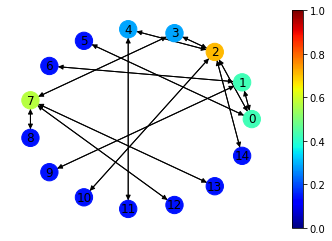

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A = [[0,1,1,0,0,1,0,0,0,0,0,0,0,0,0],
[1,0,0,0,0,0,1,0,0,1,0,0,0,0,0],
[1,0,0,1,1,0,0,0,0,0,1,0,0,0,1],
[0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,1,0,0,0,1,1,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]


A_mtx = np.matrix(A)
G = nx.from_numpy_matrix(A_mtx, create_using=nx.DiGraph())

nx.draw_networkx_edges(G,pos=nx.circular_layout(G))
nodes=nx.draw_networkx_nodes(G,
                 pos=nx.circular_layout(G),
                 node_color=list(nx.degree_centrality(G).values()),
                 cmap=plt.cm.jet,
                 vmin=0,vmax=1,with_labels=True)
nx.draw_networkx_labels(G, pos=nx.circular_layout(G),font_color='black')

plt.axis("off")
plt.colorbar(nodes)
plt.show()

### 2.4.2 Closeness Centrality

The closeness centrality C(node) is defined as the reciprocal mean distance (length of
the geodesics) from a node to all other reachable nodes in the network. It
shows how close the node is to the rest of the graph. This centrality is also
in the range from 0 (the node has no neighbors; it is severed from the rest of
the network) to 1 (the node is the hub of the global star and is one hop away
from any other node). 

$C(node) = \frac{N-1}{\sum_{1}^{N-1}D(node,v)}$,

where  $D(node,v)$ is the shortest distance between vertices $node$  and $v$.

**A node with a high closeness centrality may be capable of affecting the entire
network**.

In [29]:
max(nx.closeness_centrality(G),key=nx.closeness_centrality(G).get)

'Graph (Discrete Mathematics)'

In [30]:
nx.closeness_centrality(G)['Graph (Discrete Mathematics)']

0.022761793428126093

**Guided Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


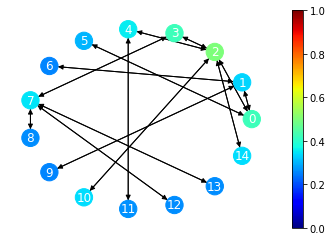

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A = [[0,1,1,0,0,1,0,0,0,0,0,0,0,0,0],
[1,0,0,0,0,0,1,0,0,1,0,0,0,0,0],
[1,0,0,1,1,0,0,0,0,0,1,0,0,0,1],
[0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,1,0,0,0,1,1,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]



A_mtx = np.matrix(A)
G = nx.from_numpy_matrix(A_mtx, create_using=nx.DiGraph())

nx.draw_networkx_edges(G,pos=nx.circular_layout(G))
nodes=nx.draw_networkx_nodes(G,
                 pos=nx.circular_layout(G),
                 node_color=list(nx.closeness_centrality(G).values()),
                 cmap=plt.cm.jet,
                 vmin=0,vmax=1,with_labels=True)
nx.draw_networkx_labels(G, pos=nx.circular_layout(G),font_color='white')

plt.axis("off")
plt.colorbar(nodes)
plt.show()

### 2.4.3 Betweenness Centrality

The betweenness centrality is for control freaks. **It measures the fraction of
all possible geodesics that pass through a node**. 


$
\displaystyle betweenness(v) = \sum_{s\neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$

where ${\displaystyle \sigma _{st}}$  is the total number of shortest paths from node ${\displaystyle s}$  to node ${\displaystyle t}$  and ${\displaystyle \sigma _{st}(v)}$ is the number of those paths that pass through ${\displaystyle v}$.

- If the betweenness is high, the node is potentially a crucial go-between (thus the name) and has a brokerage capability. 

The removal of such a node would disrupt communications in communication networks, lengthen geodesics, lower closeness centralities, and possibly split the network into disconnected components.

You can often find high-betweenness nodes in the vicinity of bridges. A
bridge is an edge whose removal would disconnect the network or significantly
increase the length of the geodesics. The latter kind of bridge is called
a **local bridge**.

In [32]:
max(nx.betweenness_centrality(G),key=nx.betweenness_centrality(G).get)

'Computer Science'

In [0]:
nx.betweenness_centrality(G)["Computer Science"]

**Guided Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


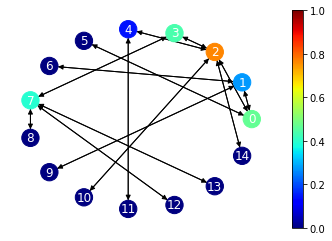

In [0]:
import numpy as np
import matplotlib.pyplot as plt

A = [[0,1,1,0,0,1,0,0,0,0,0,0,0,0,0],
[1,0,0,0,0,0,1,0,0,1,0,0,0,0,0],
[1,0,0,1,1,0,0,0,0,0,1,0,0,0,1],
[0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,1,0,0,0,1,1,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]



A_mtx = np.matrix(A)
G = nx.from_numpy_matrix(A_mtx, create_using=nx.DiGraph())

nx.draw_networkx_edges(G,pos=nx.circular_layout(G))
nodes=nx.draw_networkx_nodes(G,
                 pos=nx.circular_layout(G),
                 node_color=list(nx.betweenness_centrality(G).values()),
                 cmap=plt.cm.jet,
                 vmin=0,vmax=1,with_labels=True)
nx.draw_networkx_labels(G, pos=nx.circular_layout(G),font_color='white')

plt.axis("off")
plt.colorbar(nodes)
plt.show()

### 2.4.4 Eigenvector Centrality

Unlike the previously introduced centrality measures that rely on the neighborhoods
and geodesics to calculate the importance, the eigenvector centrality
uses a recursive definition of it: **“Tell me who your friends are, and I will
tell you who you are.”**


Mathematically, the eigenvector centrality of a node is the sum of the neighbors’ eigenvector centralities divided by $\lambda$—the largest eigenvalue of the adjacency matrix of the network.

High eigenvector centrality identifies nodes that are surrounded by other
nodes with high eigenvector centrality. **You can use this measure to locate
groups of interconnected nodes with high prestige**.

In [33]:
max(nx.eigenvector_centrality(G),key=nx.eigenvector_centrality(G).get)

'Graph (Discrete Mathematics)'

In [34]:
nx.eigenvector_centrality(G)['Graph (Discrete Mathematics)']

0.18147619124841263

**Guided Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


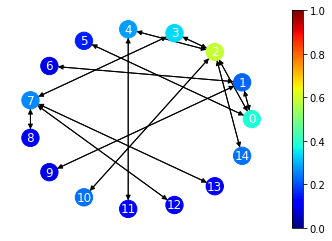

In [0]:
import numpy as np
import matplotlib.pyplot as plt

A = [[0,1,1,0,0,1,0,0,0,0,0,0,0,0,0],
[1,0,0,0,0,0,1,0,0,1,0,0,0,0,0],
[1,0,0,1,1,0,0,0,0,0,1,0,0,0,1],
[0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,1,0,0,0,1,1,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]


A_mtx = np.matrix(A)
G = nx.from_numpy_matrix(A_mtx, create_using=nx.DiGraph())

nx.draw_networkx_edges(G,pos=nx.circular_layout(G))
nodes=nx.draw_networkx_nodes(G,
                 pos=nx.circular_layout(G),
                 node_color=list(nx.eigenvector_centrality(G).values()),
                 cmap=plt.cm.jet,
                 vmin=0,vmax=1,with_labels=True)
nx.draw_networkx_labels(G, pos=nx.circular_layout(G),font_color='white')

plt.axis("off")
plt.colorbar(nodes)
plt.show()

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

1. Compare the results of section **Choose the Right Centralities** with Gephi.

In [0]:
nx.write_graphml(G,"circle.graphml")

In [0]:
# put your figures here